In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [16]:

# Load the data
data = pd.read_csv('AAPL (1).csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [18]:
df = pd.read_csv('AAPL (1).csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600
...,...,...,...,...,...,...,...
10404,2022-03-18,160.509995,164.479996,159.759995,163.979996,163.979996,123351200
10405,2022-03-21,163.509995,166.350006,163.009995,165.380005,165.380005,95811400
10406,2022-03-22,165.509995,169.419998,164.910004,168.820007,168.820007,81532000
10407,2022-03-23,167.990005,172.639999,167.649994,170.210007,170.210007,98062700


In [19]:
df = df[['Date','Close']]
df

,Date,Close
0,1980-12-12,0.128348
1,1980-12-15,0.121652
2,1980-12-16,0.112723
3,1980-12-17,0.115513
4,1980-12-18,0.118862
...,...,...
10404,2022-03-18,163.979996
10405,2022-03-21,165.380005
10406,2022-03-22,168.820007
10407,2022-03-23,170.210007


In [20]:
import datetime
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)
datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [21]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

C:\Users\anjal\AppData\Local\Temp\ipykernel_14972\2565755782.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0       1980-12-12
1       1980-12-15
2       1980-12-16
3       1980-12-17
4       1980-12-18
           ...    
10404   2022-03-18
10405   2022-03-21
10406   2022-03-22
10407   2022-03-23
10408   2022-03-24
Name: Date, Length: 10409, dtype: datetime64[ns]

In [22]:
df.index = df.pop('Date')
df

,Close
Date,
1980-12-12,0.128348
1980-12-15,0.121652
1980-12-16,0.112723
1980-12-17,0.115513
1980-12-18,0.118862
...,...
2022-03-18,163.979996
2022-03-21,165.380005
2022-03-22,168.820007


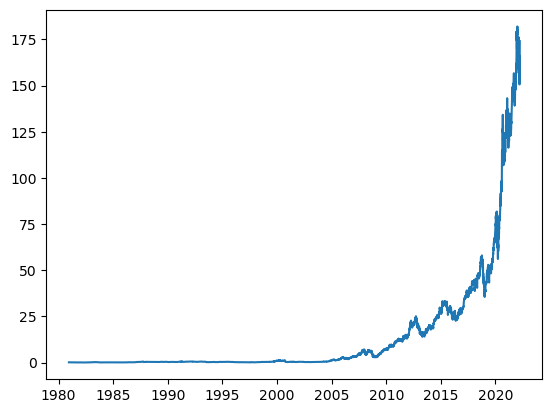

In [25]:
plt.plot(df.index, df['Close'])

In [26]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-03-25', 
                                '2022-03-23', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,123.389999,122.540001,120.089996,120.589996
1,2021-03-26,122.540001,120.089996,120.589996,121.209999
2,2021-03-29,120.089996,120.589996,121.209999,121.389999
3,2021-03-30,120.589996,121.209999,121.389999,119.900002
4,2021-03-31,121.209999,121.389999,119.900002,122.150002
...,...,...,...,...,...
247,2022-03-17,150.619995,155.089996,159.589996,160.619995
248,2022-03-18,155.089996,159.589996,160.619995,163.979996
249,2022-03-21,159.589996,160.619995,163.979996,165.380005
250,2022-03-22,160.619995,163.979996,165.380005,168.820007


In [27]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

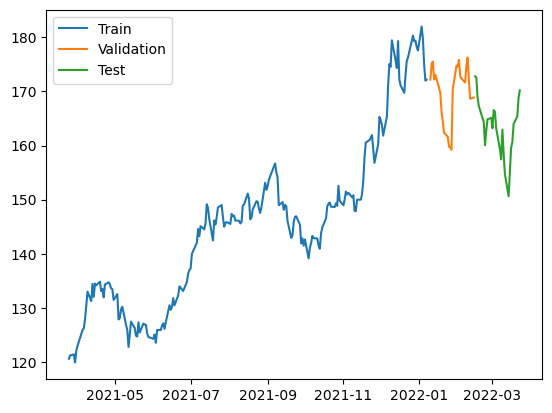

In [28]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

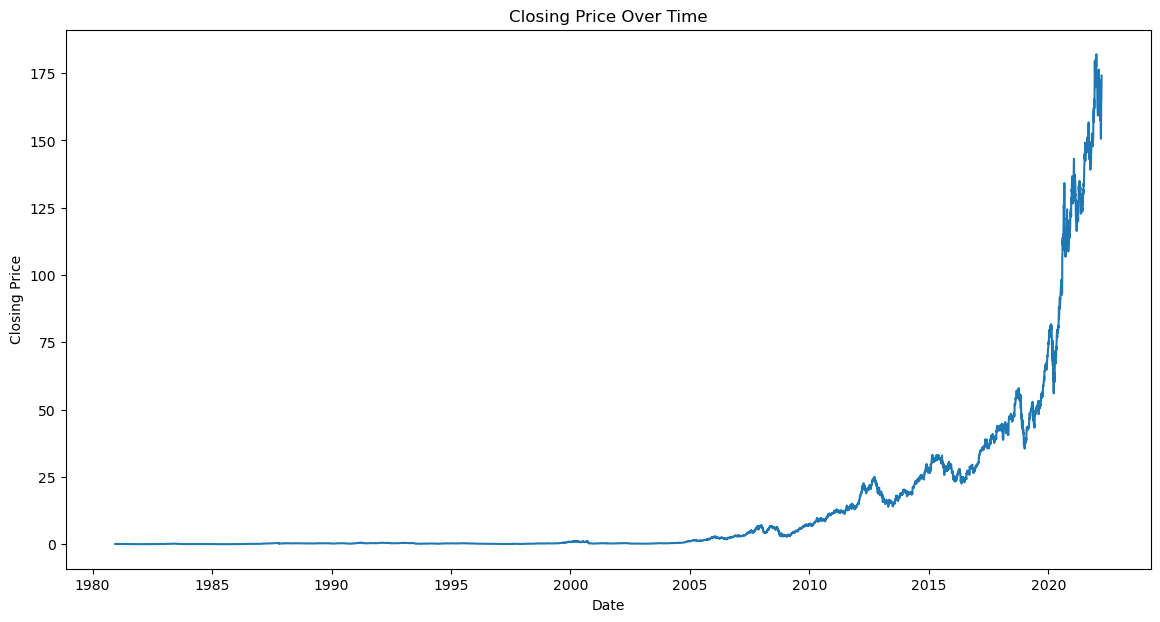

In [6]:
# Plot closing price over time
plt.figure(figsize=(14, 7))
plt.plot(data['Close'])
plt.title('Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

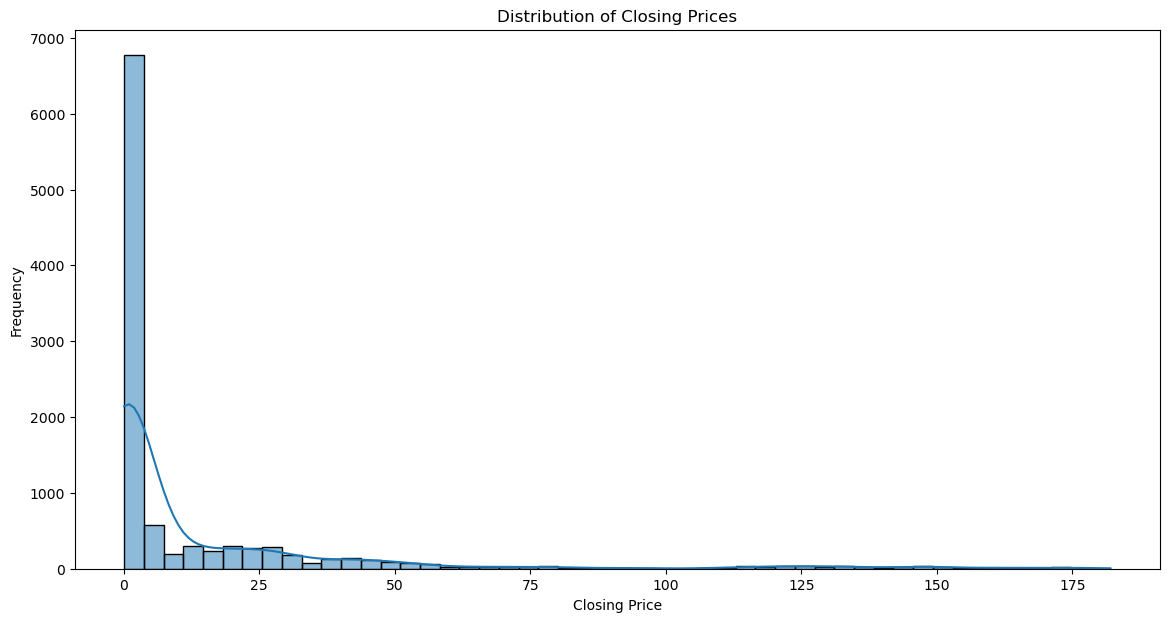

In [7]:
# Plot distribution of closing prices
plt.figure(figsize=(14, 7))
sns.histplot(data['Close'], bins=50, kde=True)
plt.title('Distribution of Closing Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.show()

In [10]:
# Prepare data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

prediction_days = 60
x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [11]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25


C:\Users\anjal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0020
Epoch 2/25
324/324 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 8.1462e-05
Epoch 3/25
324/324 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 7.0949e-05
Epoch 4/25
324/324 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 6.3807e-05
Epoch 5/25
324/324 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 5.8183e-05
Epoch 6/25
324/324 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 4.5244e-05
Epoch 7/25
324/324 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 4.5001e-05
Epoch 8/25
324/324 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 5.5538e-05
Epoch 9/25
324/324 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 4.5171e-05
Epoch 10/25
324/324 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 4.0727e-05
Epoch 11/25
324/324 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 3.6641e-05
Epoch 12/25
324/324 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 3.8042e-05
Epoch 13/25
324/324 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 3.3041e-05
Epoch 14/25
324/324 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 2.7230e-05
Ep

In [15]:
# Test the model
test_data = data['Close'][-prediction_days:].values
total_data = np.concatenate((scaled_data, scaler.transform(test_data.reshape(-1, 1))), axis=0)

x_test = []
for x in range(prediction_days, len(total_data)):
    x_test.append(total_data[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


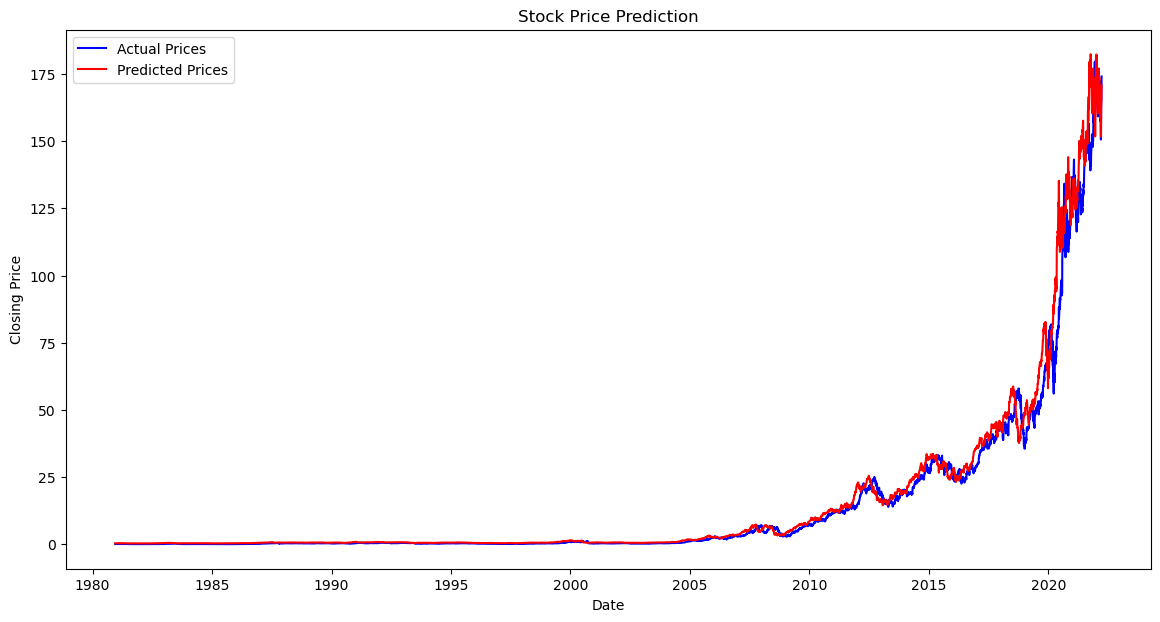

In [13]:
# Plot the predicted prices
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], color='blue', label='Actual Prices')
plt.plot(data.index[-len(predicted_prices):], predicted_prices, color='red', label='Predicted Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()